# Programming Assignment 4 - Pegasos: Sub-gradient Descent Algorithm for Softmargin Primal SVM

In this assignment, you will perform handwritten digit classification using the MNIST dataset of handwritten digits. Each example represents an image of a digit (size $28\times 28$) that has been flattened into a feature vector of length $784$. Each feature specifies a grayscale pixel value.

You will apply SVMs to automatically classify the digits. Note: we will be using a simplified multiclass one-vs-rest approach. (While you will not transform the data in this assignment, please note that SVMs can classify digits with a $1.1\%$ error rate if we applied a degree 4 polynomial transformation to the data.) 

This assignment has 3 components:
* Step 1: Implement the Pegasos algorithm to perform binary classification. You will be asked to distinguish a handwritten 0 from any other handwritten digit. 
* Step 2: Perform multiclass classification using the Pegasos binary classification algorithm you wrote in step 1. You will use a simplified one-vs-rest approach to automatically classify digits.
* Step 3: Try different hyperparameters to see if you can improve the accuracy of automatically classifying digits. Please include a short writeup describing the techniques you used and the effectiveness of each of them. 

In [1]:
# import the necessary libraries
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## Loading the dataset

In [2]:
# Read in the dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print("Number of examples:", X.shape)

c:\Users\santo\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of examples: (70000, 784)


## Preparing the dataset

We will next perform 3 preprocessing steps before running the classifier:

* Split the datset into training and testing sets
* Scale the training and test set
* For step 1, we encode the '0' labels to be +1, and the non-zero labels to '-1'. 


###  Split the dataset into a training, validation and test set.

In [202]:
# Splitting the dataset 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)

In [4]:
# Check to make sure everything is as expected
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))


X_train:(60542, 784)
y_train:(60542,)
X_val: 	(4557, 784)
y_val: 	(4557,)
X_test: (4901, 784)
y_test: (4901,)


### Looking at 4 training examples

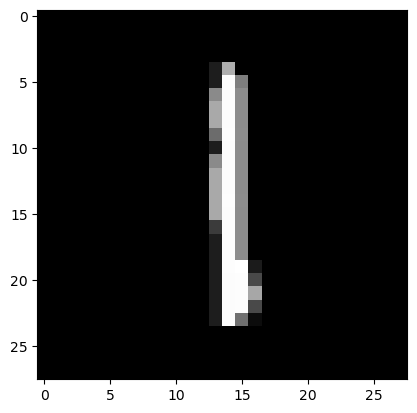

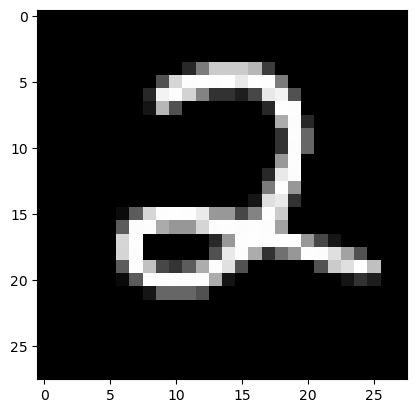

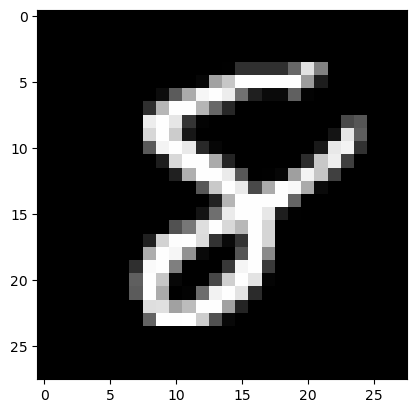

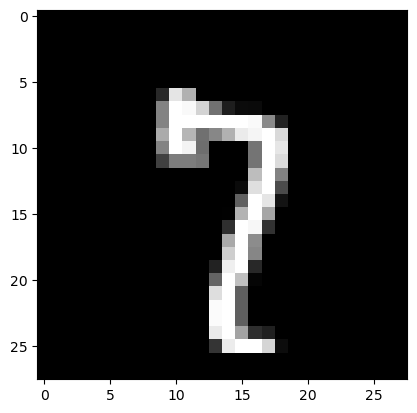

In [5]:
# What the examples looks like. Note, the feature  vector was rescaled to be 28x28
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [203]:
# Normalizing the features, so each feature is in the range [-1,1].  
# In this datset, each feature has a minimum value of 0 and a maximum value of 255.
X_train = 2*X_train/255 -1
X_val = 2*X_val/255-1
X_test = 2*X_test/255-1
X_train_val = 2*X_train_val/255 -1

### Looking at 4 training examples after scaling

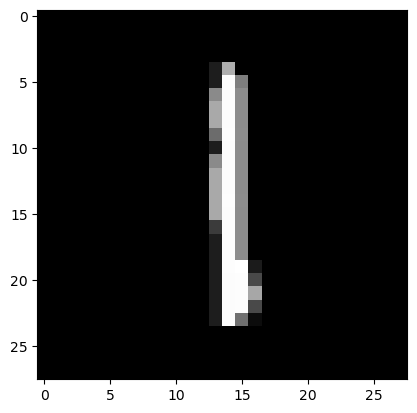

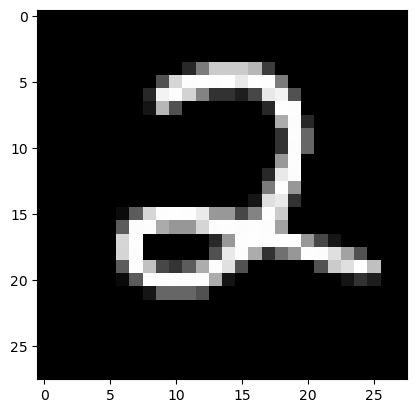

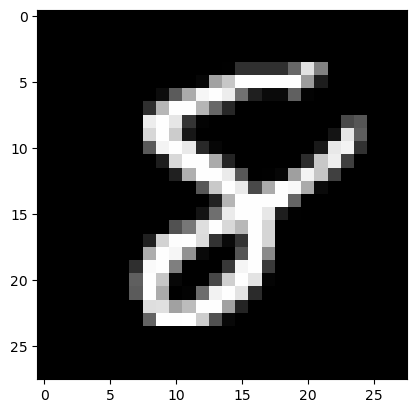

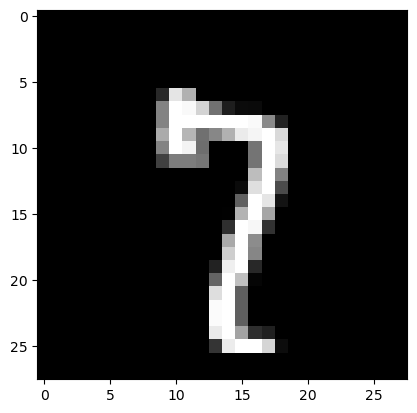

In [7]:
# What the dataset looks like after scaling
for i in range(4):  
  pyplot.imshow(X_train[i].reshape((28,28)), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

# Step 1: Binary Classification Using the Pegasos algorithm

Before writing the Pegasos algorithm, we will write 3 helper functions:

First, we will need a preprocessing step to encode the labels so that:
* one class has label 1 
* the other class has label -1

Second, we will write the function that computes $X{\bf w}$

Third, we will write the function that computes the objective function. During the Pegasos subgradient descent algorithm, we will look at how the function is changing


### Encoding function.  We will use this function in step 1 and step 2.

In [9]:
# The original labels are '1', '2', ... '9'. Our SVM algorithm Pegasos expects the labels to be encoded as +1 and -1
# Here we encode one digit as 1, and we encode the other 9 digits as -1
def one_vs_rest_encoding(y, digit = '0'):

    # Let y_encoded be an numpy array of encoded digits, with 1 for the digit we want to predict, and -1 for the rest
    # This may take several lines of code, but please store your final encoding in y_encoded

    y_encoded = np.where(y==digit,1,-1)
    
    return  y_encoded


In [14]:
# Perform the encoding for step 1's task
y_train_0_vs_rest = one_vs_rest_encoding(y_train, '0')
y_val_0_vs_rest =  one_vs_rest_encoding(y_val, '0')



### Write the function $score(X,w)$ that computes $X{\bf w}$

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix

In [17]:
# Compute the score for each example in X
def score(X, w):
    # To do
    s=np.dot(X,w)

    return s 



### Write the SVM objective function: 
$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$.  You don't need to include $w_0$ in your objective function.

* ${\bf w}$ is a d-dimenional coefficient  vector
* $X$ is the design matrix
* $\bf y$ is the target vector

In [19]:
def svm_objective(w, X, y, lambda1=.1):
    # To do. This part may require several lines of code. 
    # Store your answer in result. 
    sc=score(X,w)

    hloss=np.maximum(0,1-y*sc)

    r=0.5*lambda1*np.sum(w**2)


    result = r+np.sum(hloss)
    return result

### Write the Pegasos binary classification algorithm


* `X_train`  is the design matrix 
* `y_train`  is the target vector
* `lambda1` is the tuning parameter. Note we couldn't call it lambda, since lambda is a reserved word in python.


The update step is:

$
\text{if } y^{(i)}({\bf w}^T{\bf x}^{(i)}\ge 1)  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha\lambda {\bf w}\\
\text{else }  \\
\phantom{abcd} {\bf w} = {\bf w}-\alpha(\lambda {\bf w}-y^{(i)}{\bf x}^{(i)})
$


In [173]:
# stochastic sub-gradient descent
def pegasos(X_train, y_train, lambda1=0.08, num_iters = 10):

    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):
     
        print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range (N):
            t = t + 1
            alph=1/(lambda1*t)
          

            sc=score(X_train[i,:],w)
            # Complete the following code to find w. This will require several lines of code.
            if(y_train[i]*sc>=1):
                w=w-(alph*lambda1*w)
            else:
                w=w-alph*((lambda1*w)-(y_train[i]*X_train[i,:]))

             
        
    return w

## Step 2: Multiclass Classification
Implement multi-class prediction using one-versus-all classification.

### First: Train 10 binary classifiers using the Pegasos algorithm from the previous question.
For each digit you will create a classifier:
* Relabel labels equal to the digit to 1
* Relabel the other 9 labels to -1
* Use the Pegasos algorithm to get the weight vector (the classifier)

Following this step, you will have 10 distinct weight vectors.

### Second: Predict the label of the validation set.
To predict the label of a single example ${\bf x}$:
* Compute the dot product of ${\bf x}$ with each weight vector. You will have 10 scores (one for each classifier).
* Predict the label corresponding to the class that had the maximum score.

Note this is a simple method for choosing the label. For a more sophisticated approach read: https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=One%20standard%20way%20to%20obtain,validation%20on%20the%20training%20data.

### Third: Find the accuracy of the classifier based on the validation set 
For each label, observe how the classifier performed on the validation set. 

In [178]:
# Create the 10 classifiers
labels = "0123456789"
w_vals= {}
val_scores = {}
for i in range(len(labels)):
    # Note that each section may require more than one line of code.
    
    # Perform one-vs-rest for labels[i]
    # To do: Relabel the y labels in the train set to either 1 or -1 using one_vs_rest_encoding
    y_encoded =one_vs_rest_encoding(y_train, digit = labels[i])
    # To do: Use the Pegasos algorithm on X_train and y_encoded to get the weight vector
    w_vals[i] =pegasos(X_train,y_encoded,0.08,30)
    
    # Estimate accuracy for one-vs-rest classifier for labels[i]
    # To do:  Relabel the y labels in the validation set to either 1 or -1 using one_vs_rest_encoding
    y_encoded_val =one_vs_rest_encoding(y_val, digit = labels[i])
    # To do: Accuracy Estimation for one-vs-rest classifier for labels[i]
    sc=score(X_val,w_vals[i])
    p=np.sign(sc)
    c=np.sum(p==y_encoded_val)

    l=len(y_val)
    a=c/l






    val_scores[i] = a

Iteration 0. J: 3063352.125490
Iteration 1. J: 1996.219802
Iteration 2. J: 2012.731305
Iteration 3. J: 2007.266573
Iteration 4. J: 2011.785653
Iteration 5. J: 2016.052305
Iteration 6. J: 2018.906208
Iteration 7. J: 2021.880819
Iteration 8. J: 2023.868195
Iteration 9. J: 2026.588501
Iteration 10. J: 2028.962698
Iteration 11. J: 2027.663325
Iteration 12. J: 2028.567860
Iteration 13. J: 2027.781771
Iteration 14. J: 2028.468142
Iteration 15. J: 2027.340186
Iteration 16. J: 2028.307058
Iteration 17. J: 2027.938664
Iteration 18. J: 2028.716987
Iteration 19. J: 2029.053080
Iteration 20. J: 2028.632050
Iteration 21. J: 2028.084111
Iteration 22. J: 2028.468223
Iteration 23. J: 2027.813571
Iteration 24. J: 2027.312005
Iteration 25. J: 2027.223547
Iteration 26. J: 2026.910460
Iteration 27. J: 2027.123236
Iteration 28. J: 2026.967575
Iteration 29. J: 2026.653909
Iteration 0. J: 4537922.423529
Iteration 1. J: 2156.656603
Iteration 2. J: 2177.217330
Iteration 3. J: 2187.376275
Iteration 4. J: 2200.2

In [179]:
# Check your work. With the proper amount of iterations, your values should range from 0.95 to 0.99  
for i in range(len(labels)):
     print(i,": score:", val_scores[i])

0 : score: 0.9905639675224929
1 : score: 0.9872723282861532
2 : score: 0.9769585253456221
3 : score: 0.9708141321044547
4 : score: 0.9765196401141102
5 : score: 0.9615975422427036
6 : score: 0.9855167873601053
7 : score: 0.97871406627167
8 : score: 0.9543559359227562
9 : score: 0.9605003291639236


In [180]:
# To do: Predict the label for each example in the validation set 
# We will let eval be a numpy array of length N, where N is the number of examples in the validation set. 
# eval1 will hold either a 1 or a 0, depending if the handwritten digit was predicted correctly or not.
g1=len(X_val)
eval1 = np.zeros(g1)





# To do: Loop through each sample in the validation set and assign it a label based on the highest score. 
# Store either a 1 if the number was predicted correctly, or a 0 if the number was predicted incorrectly.
for i in range(g1):
    sc=np.zeros(g1)
    g2=len(labels)
    for j in range(g2):
        sc[j]=score(X_val[i,:],w_vals[j])
    

    

        

    ypred=np.argmax(sc)
    if(ypred==int(y_val[i])):
        eval1[i]=1
    else:
        eval1[i]=0






In [181]:
# To do: Determine how many were predicted correctly (Find its accuracy score)
cc1=0
for i in range(g1):
    if(eval1[i]==1):
        cc1=cc1+1
   


accuracy = cc1/g1
print("Accuracy Score for validation set:",accuracy)

g1=len(X_test)
eval1 = np.zeros(g1)





# To do: Loop through each sample in the validation set and assign it a label based on the highest score. 
# Store either a 1 if the number was predicted correctly, or a 0 if the number was predicted incorrectly.
for i in range(g1):
    sc=np.zeros(g1)
    g2=len(labels)
    for j in range(g2):
        sc[j]=score(X_test[i,:],w_vals[j])
    

    

        

    ypred=np.argmax(sc)
    if(ypred==int(y_test[i])):
        eval1[i]=1
    else:
        eval1[i]=0



cc1=0
for i in range(g1):
    if(eval1[i]==1):
        cc1=cc1+1
   


accuracy = cc1/g1
print("Accuracy Score for test set:",accuracy)        

Accuracy Score for validation set: 0.7897739741057713
Accuracy Score for test set: 0.7959600081615996


# Step 3: Hyper-parameter Choices

* See if you can find better hyper-parameter settings
* Once you have found the best settings, rerun the algorithm using the data from both validation and training sets.
* Evaluate your performance on the test data.
* In a markdown comment, please discuss the techniques you used. You may discuss how you found your hyper-parameters, if the techniques worked/didn't work, etc. Please be concise. We are expecting this to be a short paragraph in length. 


In [209]:
# Create the 10 classifiers

labels = "0123456789"
w_vals= {}
val_scores = {}
for i in range(len(labels)):
    # Note that each section may require more than one line of code.
    
    # Perform one-vs-rest for labels[i]
    # To do: Relabel the y labels in the train set to either 1 or -1 using one_vs_rest_encoding
    y_encoded =one_vs_rest_encoding(y_train_val, digit = labels[i])
    # To do: Use the Pegasos algorithm on X_train and y_encoded to get the weight vector
    w_vals[i] =pegasos(X_train_val,y_encoded,0.001,200)
    
   
   






    










g1=len(X_test)
eval1 = np.zeros(g1)





# To do: Loop through each sample in the validation set and assign it a label based on the highest score. 
# Store either a 1 if the number was predicted correctly, or a 0 if the number was predicted incorrectly.
for i in range(g1):
    sc=np.zeros(g1)
    g2=len(labels)
    for j in range(g2):
        sc[j]=score(X_test[i,:],w_vals[j])
    

    

        

    ypred=np.argmax(sc)
    if(ypred==int(y_test[i])):
        eval1[i]=1
    else:
        eval1[i]=0



cc1=0
for i in range(g1):
    if(eval1[i]==1):
        cc1=cc1+1
   


accuracy = cc1/g1
print("Accuracy Score for test set:",accuracy)       

Iteration 0. J: 3276682.011765
Iteration 1. J: 5133.593038
Iteration 2. J: 2780.315272
Iteration 3. J: 1943.886656
Iteration 4. J: 1911.129861
Iteration 5. J: 1680.325182
Iteration 6. J: 1612.775759
Iteration 7. J: 1586.338452
Iteration 8. J: 1539.068192
Iteration 9. J: 1545.690319
Iteration 10. J: 1489.242339
Iteration 11. J: 1400.777721
Iteration 12. J: 1429.344093
Iteration 13. J: 1367.719326
Iteration 14. J: 1351.060125
Iteration 15. J: 1353.160446
Iteration 16. J: 1329.770144
Iteration 17. J: 1431.493207
Iteration 18. J: 1447.730251
Iteration 19. J: 1467.914608
Iteration 20. J: 1306.597491
Iteration 21. J: 1460.179098
Iteration 22. J: 1314.750149
Iteration 23. J: 1316.021437
Iteration 24. J: 1323.206646
Iteration 25. J: 1327.191188
Iteration 26. J: 1292.982669
Iteration 27. J: 1338.804691
Iteration 28. J: 1326.624231
Iteration 29. J: 1334.172878
Iteration 30. J: 1318.099115
Iteration 31. J: 1281.728099
Iteration 32. J: 1325.722627
Iteration 33. J: 1335.663905
Iteration 34. J: 1327

Inorder to find the best hyperparameters I have used Trial and error with the intial setting the accuracy on both the validation and test sets were low which was indicating underfitting so I decreased the regularization term ie the penalty with lambda=0.001 and no of iterations=200 along with this the model was trained on the entire train+validation set which helped increase the accuracy to 86.2% on the test dataset.